# Library Imports

In [1]:
import numpy as np
import pandas as pd

from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

!pip install -q darts --use-deprecated=legacy-resolver
from darts import TimeSeries
from darts.models import ARIMA, AutoARIMA
from darts.utils.statistics import plot_acf, plot_pacf, stationarity_test_adf
from darts.metrics.metrics import mape
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Data Pre-processing

We convert the string's with commas to integers, and the float columns to float<br>
Also, transform YEAR and MONTH to a single MONTH with datetime type, and sort the dataframe according to that

In [2]:
df = pd.read_csv("/kaggle/input/air-traffic-prediction/AirtrafficA4.csv")
for col in df.columns[3:-2]:
    df[col] = pd.to_numeric(df[col].str.replace(",", ""), errors='coerce').astype('Int64')

df[df.columns[-2]] = pd.to_numeric(df[df.columns[-2]].str.replace(",", ""), errors='coerce').astype('float64')
df[df.columns[-1]] = pd.to_numeric(df[df.columns[-1]].str.replace(",", ""), errors='coerce').astype('float64')
df["MONTH"] = df["MONTH"].apply(lambda x : x.strip()).replace("JUNE", "JUN").replace("JULY", "JUL")

df['MONTH'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'], format='%Y-%b')
df = df.drop("YEAR", axis=1)
df = df.sort_values("MONTH", ignore_index=True)

df.head()

,AIRLINE,MONTH,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,PASSENGERS CARRIED,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE)
0,A007,2013-01-01,10552,18655,10112,1408012,1820105,6465.0,0.0
1,A007,2013-02-01,9873,17374,9439,1341210,1698930,6235.0,0.0
2,A007,2013-03-01,11393,20093,11028,1423569,1984886,6505.0,0.0
3,A007,2013-04-01,11426,20084,11090,1511094,1996084,5903.0,0.0
4,A007,2013-05-01,11885,20779,11533,1685168,2075882,7345.0,0.0


In [3]:
df.isna().sum()

AIRLINE                                   0
MONTH                                     0
TOTAL DEPARTURES                          1
HOURS FLOWN                               1
KILOMETRE FLOWN                           1
PASSENGERS CARRIED                        1
AVAILABLE SEAT KILOMETRE (IN THOUSAND)    1
 FREIGHT CARRIED (IN TONNE)               1
MAIL CARRIED (IN TONNE)                   2
dtype: int64

There are a only 2 rows with null values

<Axes: xlabel='MONTH'>

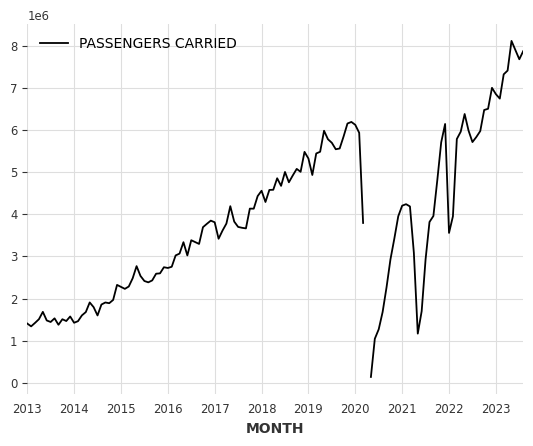

In [4]:
df.plot(x="MONTH", y="PASSENGERS CARRIED")

The sudden dip in PASSENGERS CARRIED cooresponds to COVID-19 period. We remove that entirely, as the jump from 2020-02-01 to 2022-03-01 seems nearly continuous

In [5]:
non_covid_mask = ~((df["MONTH"] >= "2020-03-01") & (df["MONTH"] <= "2022-02-28"))

<Axes: xlabel='time'>

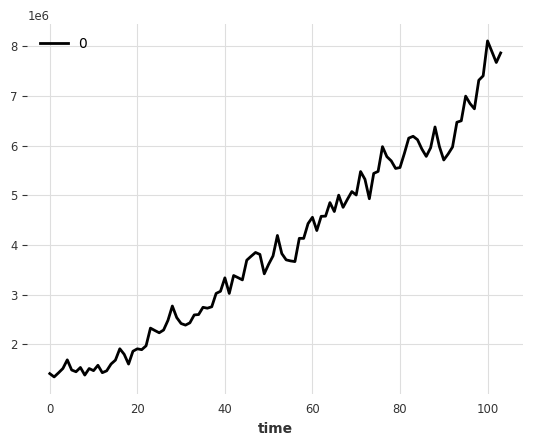

In [6]:
series = TimeSeries.from_values(df[non_covid_mask]["PASSENGERS CARRIED"])
series.plot()

# Stationarity and Parameters

In [7]:
stationarity_test_adf(series)

(1.3474873588608705,
 0.9968620250885537,
 12,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 2454.418229443146)

The time series has p value of 0.9968, it is not stationary. The second difference, however looks stationary, so d value 2 is optimal.

<Axes: xlabel='time'>

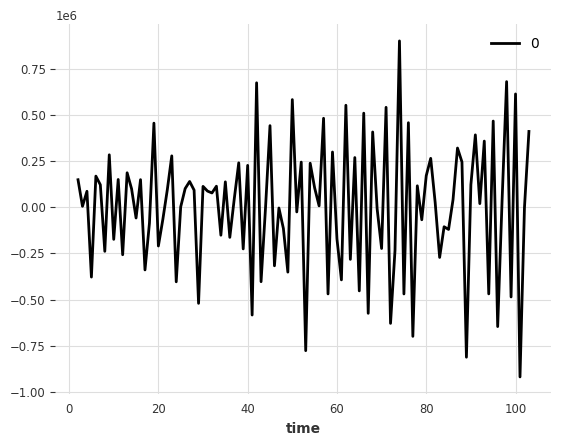

In [8]:
series.diff(2).plot()

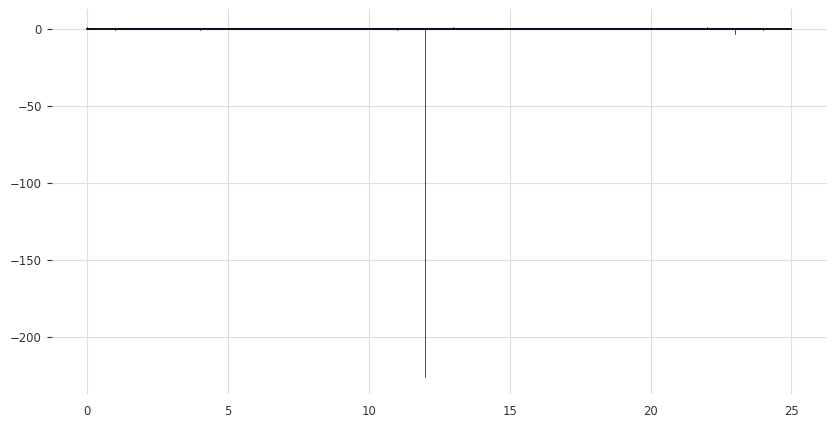

In [9]:
plot_pacf(series.diff(2))

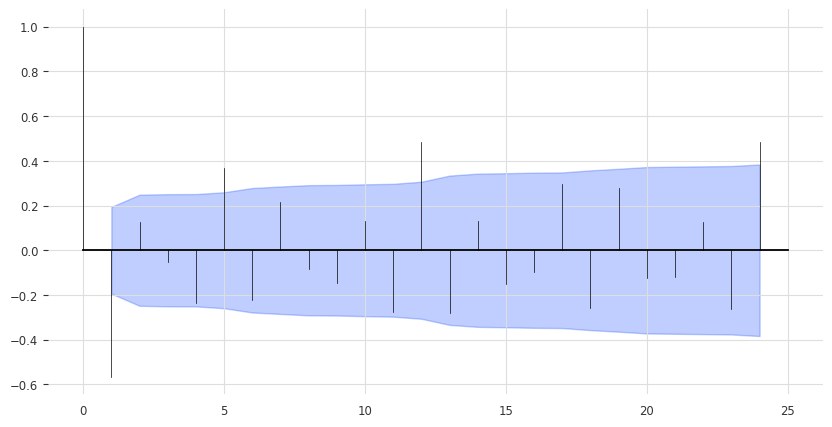

In [10]:
plot_acf(series.diff(2))

# Model Training

We make a train-test-split of 0.8 ratio

In [11]:
train_size = int(0.8 * len(series))
train, test = series[:train_size], series[train_size:]

Using AutoARIMA model with seasonality to make predictions. Also, D=2 as shown earlier for stationarity

In [12]:
model = AutoARIMA(seasonal=True, m=12, D=2, trace=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,2,1)[12]             : AIC=1635.466, Time=1.01 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=1711.957, Time=0.03 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=1641.681, Time=0.21 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=1648.505, Time=0.41 sec
 ARIMA(2,0,2)(0,2,1)[12]             : AIC=1639.031, Time=1.73 sec
 ARIMA(2,0,2)(1,2,0)[12]             : AIC=1647.571, Time=0.82 sec
 ARIMA(2,0,2)(2,2,1)[12]             : AIC=1634.965, Time=1.85 sec
 ARIMA(2,0,2)(2,2,0)[12]             : AIC=1635.067, Time=1.32 sec
 ARIMA(2,0,2)(2,2,2)[12]             : AIC=1636.781, Time=2.67 sec
 ARIMA(2,0,2)(1,2,2)[12]             : AIC=1635.517, Time=1.55 sec
 ARIMA(1,0,2)(2,2,1)[12]             : AIC=1633.308, Time=1.29 sec
 ARIMA(1,0,2)(1,2,1)[12]             : AIC=1633.699, Time=0.65 sec
 ARIMA(1,0,2)(2,2,0)[12]             : AIC=1633.449, Time=0.95 sec
 ARIMA(1,0,2)(2,2,2)[12]             : AIC=1635.088, Time=2.39 sec
 ARIMA(1,0,2)(1,2,0

AutoARIMA(add_encoders=None, seasonal=True, m=12, D=2, trace=True)

This tells us that the best parameters are p=1,d=1,q=0 and seasonal parameters P=2,D=0,Q=0

In [13]:
pred = model.predict(len(test))
print(f"The MAPE is {mape(test, pred)}")

The MAPE is 5.76388679534688


<Axes: xlabel='time'>

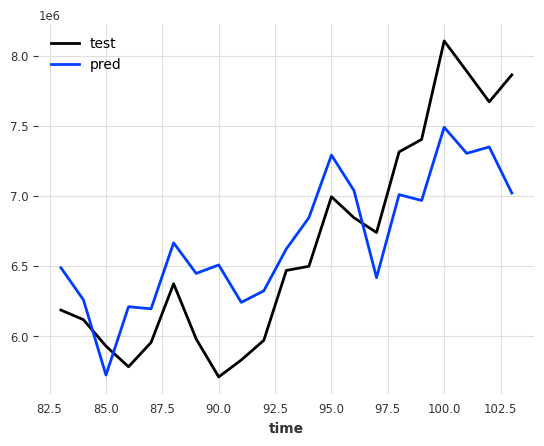

In [14]:
test.plot(label="test")
pred.plot(label="pred")

# Final Submission

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,2,1)[12]             : AIC=2243.041, Time=1.44 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=2363.725, Time=0.02 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=2253.556, Time=0.21 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=2292.511, Time=0.20 sec
 ARIMA(2,0,2)(0,2,1)[12]             : AIC=2248.836, Time=1.07 sec
 ARIMA(2,0,2)(1,2,0)[12]             : AIC=2257.940, Time=0.85 sec
 ARIMA(2,0,2)(2,2,1)[12]             : AIC=2241.328, Time=2.48 sec
 ARIMA(2,0,2)(2,2,0)[12]             : AIC=2241.973, Time=1.94 sec
 ARIMA(2,0,2)(2,2,2)[12]             : AIC=2243.252, Time=2.46 sec
 ARIMA(2,0,2)(1,2,2)[12]             : AIC=2242.634, Time=2.02 sec
 ARIMA(1,0,2)(2,2,1)[12]             : AIC=2240.649, Time=2.14 sec
 ARIMA(1,0,2)(1,2,1)[12]             : AIC=2242.408, Time=1.13 sec
 ARIMA(1,0,2)(2,2,0)[12]             : AIC=2240.948, Time=1.30 sec
 ARIMA(1,0,2)(2,2,2)[12]             : AIC=2242.557, Time=1.52 sec
 ARIMA(1,0,2)(1,2,0

<Axes: xlabel='time'>

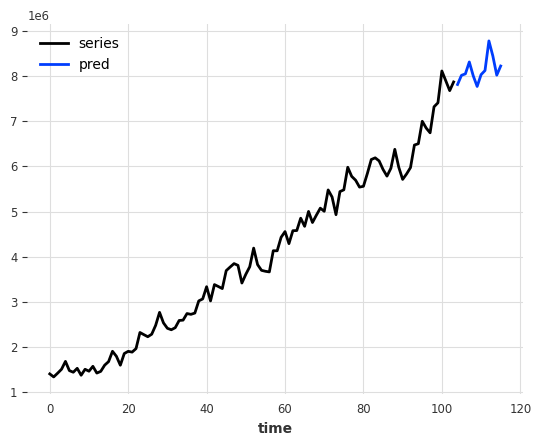

In [15]:
# Submission
model.fit(series)
pred = model.predict(12)
year_month = pd.date_range('2023-09-01', '2024-08-01', freq='MS').strftime("%Y %b").str.upper()
df_pred = pd.DataFrame({"YEAR_MONTH": year_month, "PASSENGERS CARRIED": np.squeeze(pred.values())})
df_pred.to_csv("submission.csv", index=False)

series.plot(label="series")
pred.plot(label="pred")